# FIFA24 - Statistical Analysis and Player Value Prediction

In [ ]:
#importing necessary libraries for EDA
import os
import math
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

from IPython.display import display
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")
import gc

import statsmodels.api as sm
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:

#importing the data
data = pd.read_csv('player_stats.csv', encoding='ISO-8859-1')

In [ ]:
# the attributes(columns) and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   player          5682 non-null   object
 1   country         5682 non-null   object
 2   height          5682 non-null   int64 
 3   weight          5682 non-null   int64 
 4   age             5682 non-null   int64 
 5   club            5682 non-null   object
 6   ball_control    5682 non-null   int64 
 7   dribbling       5682 non-null   int64 
 8   marking         5524 non-null   object
 9   slide_tackle    5682 non-null   int64 
 10  stand_tackle    5682 non-null   int64 
 11  aggression      5682 non-null   int64 
 12  reactions       5682 non-null   int64 
 13  att_position    5682 non-null   int64 
 14  interceptions   5682 non-null   int64 
 15  vision          5682 non-null   int64 
 16  composure       5682 non-null   int64 
 17  crossing        5682 non-null   int64 
 18  short_pa

## Exploratory Data Analysis

In [ ]:
# checking the kind of data in columns
data.head()

,player,country,height,weight,age,club,ball_control,dribbling,marking,slide_tackle,stand_tackle,aggression,reactions,att_position,interceptions,vision,composure,crossing,short_pass,long_pass,acceleration,stamina,strength,balance,sprint_speed,agility,jumping,heading,shot_power,finishing,long_shots,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes,value
0,Cristian Castro Devenish,Colombia,192,84,22,Atl. Nacional,55,43,NaN,68,73,72,68,30,65,30,50,33,64,49,41,55,86,40,52,43,51,64,54,30,31,32,34,41,33,10,11,6,7,9,$1.400.000
1,Silaldo Taffarel,Brazil,181,80,31,Corinthians,69,70,NaN,56,58,62,70,69,70,64,54,60,63,63,64,87,81,42,67,65,65,54,60,64,68,65,62,48,46,12,15,14,8,14,$975.00
2,Thomas DÃ¤hne,Germany,193,84,29,Holstein Kiel,25,12,NaN,13,16,27,65,17,20,49,48,14,35,18,46,38,68,41,48,36,60,17,51,14,20,20,15,26,16,64,74,65,68,74,$1.100.000
3,Michael Sollbauer,Austria,187,86,33,SK Rapid Wien,46,48,NaN,66,69,71,64,48,66,29,70,44,58,53,35,73,82,56,63,57,80,67,32,24,33,25,13,22,19,10,10,8,14,9,$650.00
4,Diego Segovia,Uruguay,191,80,23,Independiente,14,8,NaN,14,16,28,50,10,12,38,34,11,23,20,38,28,64,24,31,34,27,13,48,4,6,9,10,16,5,61,59,62,64,64,$300.00


In [ ]:
# checking the distribution of each column
data.describe()

,height,weight,age,ball_control,dribbling,slide_tackle,stand_tackle,aggression,reactions,att_position,interceptions,vision,composure,crossing,short_pass,long_pass,acceleration,stamina,strength,balance,sprint_speed,agility,jumping,heading,shot_power,finishing,long_shots,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes
count,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.00000,5682.000000,5682.000000,5682.000000
mean,181.670539,75.282295,26.316262,58.912179,56.128476,46.728441,48.820838,56.324006,61.959345,50.724921,47.389124,54.465681,58.620908,49.790391,59.333333,53.910771,64.754664,63.377332,65.381204,64.070398,64.958993,63.780535,65.085005,52.245336,58.182682,46.354277,47.164203,48.099789,43.299542,48.174938,42.931890,16.187610,16.43805,16.191834,16.071982,16.570222
std,6.829238,6.998971,4.729967,16.567068,18.772075,20.519430,20.975966,16.846410,8.893309,19.780636,20.451327,13.705286,12.024102,17.898054,14.326017,14.601361,15.298600,16.105897,12.624053,14.495444,15.114044,14.857875,12.274525,17.359459,12.971923,19.822642,19.463368,18.086672,17.086473,15.781737,17.912619,17.146572,17.63526,16.993154,16.808674,17.942154
min,156.000000,54.000000,17.000000,8.000000,5.000000,7.000000,7.000000,11.000000,32.000000,3.000000,3.000000,10.000000,13.000000,6.000000,11.000000,9.000000,12.000000,14.000000,25.000000,20.000000,13.000000,21.000000,23.000000,6.000000,20.000000,4.000000,5.000000,7.000000,4.000000,8.000000,4.000000,2.000000,2.00000,2.000000,2.000000,3.000000
25%,177.000000,70.000000,23.000000,55.000000,51.000000,27.000000,30.000000,45.000000,56.000000,40.000000,28.000000,45.000000,52.000000,39.000000,55.000000,46.000000,57.000000,56.000000,58.000000,56.000000,57.000000,56.000000,57.000000,45.000000,49.000000,31.000000,33.000000,36.000000,32.000000,39.000000,30.000000,8.000000,8.00000,8.000000,8.000000,8.000000
50%,182.000000,75.000000,26.000000,63.000000,62.000000,54.000000,57.000000,60.000000,62.000000,56.000000,54.000000,56.000000,60.000000,54.000000,63.000000,57.000000,68.000000,66.000000,66.500000,66.000000,68.000000,66.000000,66.000000,55.000000,59.000000,51.000000,51.000000,50.000000,43.000000,49.000000,44.000000,11.000000,11.00000,11.000000,11.000000,11.000000
75%,186.000000,80.000000,30.000000,69.000000,68.000000,64.000000,66.000000,69.000000,68.000000,65.000000,64.000000,65.000000,67.000000,63.000000,68.000000,64.000000,75.000000,74.000000,74.000000,74.000000,75.000000,74.000000,73.000000,64.000000,68.000000,62.000000,62.000000,62.000000,56.000000,60.000000,57.000000,14.000000,14.00000,14.000000,14.000000,14.000000
max,204.000000,102.000000,41.000000,94.000000,95.000000,87.000000,91.000000,96.000000,93.000000,93.000000,89.000000,94.000000,96.000000,94.000000,93.000000,93.000000,97.000000,95.000000,96.000000,95.000000,97.000000,93.000000,95.000000,93.000000,94.000000,94.000000,91.000000,93.000000,94.000000,92.000000,90.000000,90.000000,90.00000,87.000000,90.000000,89.000000


In [ ]:
# the majority of marking column is missing
#cross-checking the null values
data.isnull().sum()

player              0
country             0
height              0
weight              0
age                 0
club                0
ball_control        0
dribbling           0
marking           158
slide_tackle        0
stand_tackle        0
aggression          0
reactions           0
att_position        0
interceptions       0
vision              0
composure           0
crossing            0
short_pass          0
long_pass           0
acceleration        0
stamina             0
strength            0
balance             0
sprint_speed        0
agility             0
jumping             0
heading             0
shot_power          0
finishing           0
long_shots          0
curve               0
fk_acc              0
penalties           0
volleys             0
gk_positioning      0
gk_diving           0
gk_handling         0
gk_kicking          0
gk_reflexes         0
value               0
dtype: int64

In [ ]:
# dropping the column 'marking' as more than 90% of it is empty
data.drop(['marking'], axis=1, inplace=True)

In [ ]:
# the target column 'value' is in string format and has some un-necessary charactres such as '$' and ','
def value_conversion(value):
  if isinstance(value,object):
    out = value.replace('$','')
    if '.' in out:
      out = float(out.replace('.',''))
    return float(out)

data['value'] = data['value'].apply(lambda x: value_conversion(x))

#Scaling the value column to million
data['value'] = round(data['value']/1000000,6)
data.rename(columns={'value':'value(Million)'}, inplace=True)

In [ ]:
# checking the column distributions once again
data.describe()

,height,weight,age,ball_control,dribbling,slide_tackle,stand_tackle,aggression,reactions,att_position,interceptions,vision,composure,crossing,short_pass,long_pass,acceleration,stamina,strength,balance,sprint_speed,agility,jumping,heading,shot_power,finishing,long_shots,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes,value(Million)
count,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.000000,5682.00000,5682.000000,5682.000000,5682.000000,5682.000000
mean,181.670539,75.282295,26.316262,58.912179,56.128476,46.728441,48.820838,56.324006,61.959345,50.724921,47.389124,54.465681,58.620908,49.790391,59.333333,53.910771,64.754664,63.377332,65.381204,64.070398,64.958993,63.780535,65.085005,52.245336,58.182682,46.354277,47.164203,48.099789,43.299542,48.174938,42.931890,16.187610,16.43805,16.191834,16.071982,16.570222,2.271115
std,6.829238,6.998971,4.729967,16.567068,18.772075,20.519430,20.975966,16.846410,8.893309,19.780636,20.451327,13.705286,12.024102,17.898054,14.326017,14.601361,15.298600,16.105897,12.624053,14.495444,15.114044,14.857875,12.274525,17.359459,12.971923,19.822642,19.463368,18.086672,17.086473,15.781737,17.912619,17.146572,17.63526,16.993154,16.808674,17.942154,7.616233
min,156.000000,54.000000,17.000000,8.000000,5.000000,7.000000,7.000000,11.000000,32.000000,3.000000,3.000000,10.000000,13.000000,6.000000,11.000000,9.000000,12.000000,14.000000,25.000000,20.000000,13.000000,21.000000,23.000000,6.000000,20.000000,4.000000,5.000000,7.000000,4.000000,8.000000,4.000000,2.000000,2.00000,2.000000,2.000000,3.000000,0.000400
25%,177.000000,70.000000,23.000000,55.000000,51.000000,27.000000,30.000000,45.000000,56.000000,40.000000,28.000000,45.000000,52.000000,39.000000,55.000000,46.000000,57.000000,56.000000,58.000000,56.000000,57.000000,56.000000,57.000000,45.000000,49.000000,31.000000,33.000000,36.000000,32.000000,39.000000,30.000000,8.000000,8.00000,8.000000,8.000000,8.000000,0.035000
50%,182.000000,75.000000,26.000000,63.000000,62.000000,54.000000,57.000000,60.000000,62.000000,56.000000,54.000000,56.000000,60.000000,54.000000,63.000000,57.000000,68.000000,66.000000,66.500000,66.000000,68.000000,66.000000,66.000000,55.000000,59.000000,51.000000,51.000000,50.000000,43.000000,49.000000,44.000000,11.000000,11.00000,11.000000,11.000000,11.000000,0.077500
75%,186.000000,80.000000,30.000000,69.000000,68.000000,64.000000,66.000000,69.000000,68.000000,65.000000,64.000000,65.000000,67.000000,63.000000,68.000000,64.000000,75.000000,74.000000,74.000000,74.000000,75.000000,74.000000,73.000000,64.000000,68.000000,62.000000,62.000000,62.000000,56.000000,60.000000,57.000000,14.000000,14.00000,14.000000,14.000000,14.000000,1.600000
max,204.000000,102.000000,41.000000,94.000000,95.000000,87.000000,91.000000,96.000000,93.000000,93.000000,89.000000,94.000000,96.000000,94.000000,93.000000,93.000000,97.000000,95.000000,96.000000,95.000000,97.000000,93.000000,95.000000,93.000000,94.000000,94.000000,91.000000,93.000000,94.000000,92.000000,90.000000,90.000000,90.00000,87.000000,90.000000,89.000000,153.500000


## Visualization

In [ ]:
#checking the number of players in each club
data['club'].value_counts().reset_index()

,index,club
0,River Plate,21
1,Liverpool,17
2,LanÃºs,17
3,Holstein Kiel,16
4,Barnsley,16
...,...,...
684,Real Madrid,1
685,Liverpool,1
686,FC Bayern München,1
687,Al Nassr,1


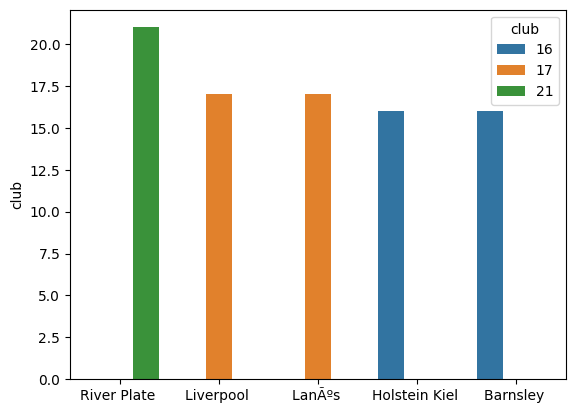

In [ ]:
club = data['club'].value_counts().nlargest(5)
sns.barplot(x=club.index, y=club,hue=club)
plt.show()

In [ ]:
#checking the number of players from each country
data['country'].value_counts().reset_index()

,index,country
0,England,516
1,Germany,390
2,Spain,356
3,France,309
4,Argentina,302
...,...,...
130,Mauritania,1
131,Central African Rep.,1
132,Guyana,1
133,Antigua & Barbuda,1


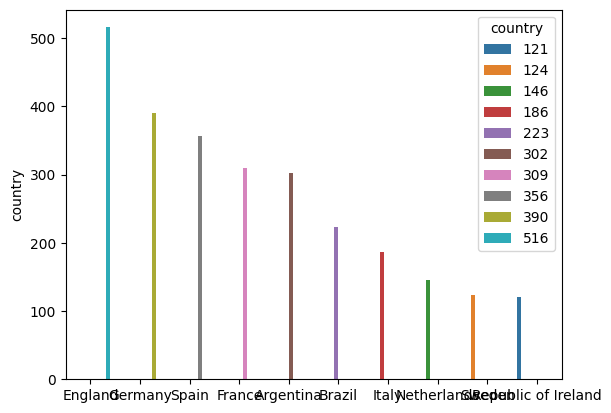

In [ ]:
country = data['country'].value_counts().nlargest(10)
sns.barplot(x=country.index, y=country,hue=country)
plt.show()

In [ ]:
num_df = data.drop(["player", "country", "club"], axis=1)

                                   [Numeric Features Distribution                                   


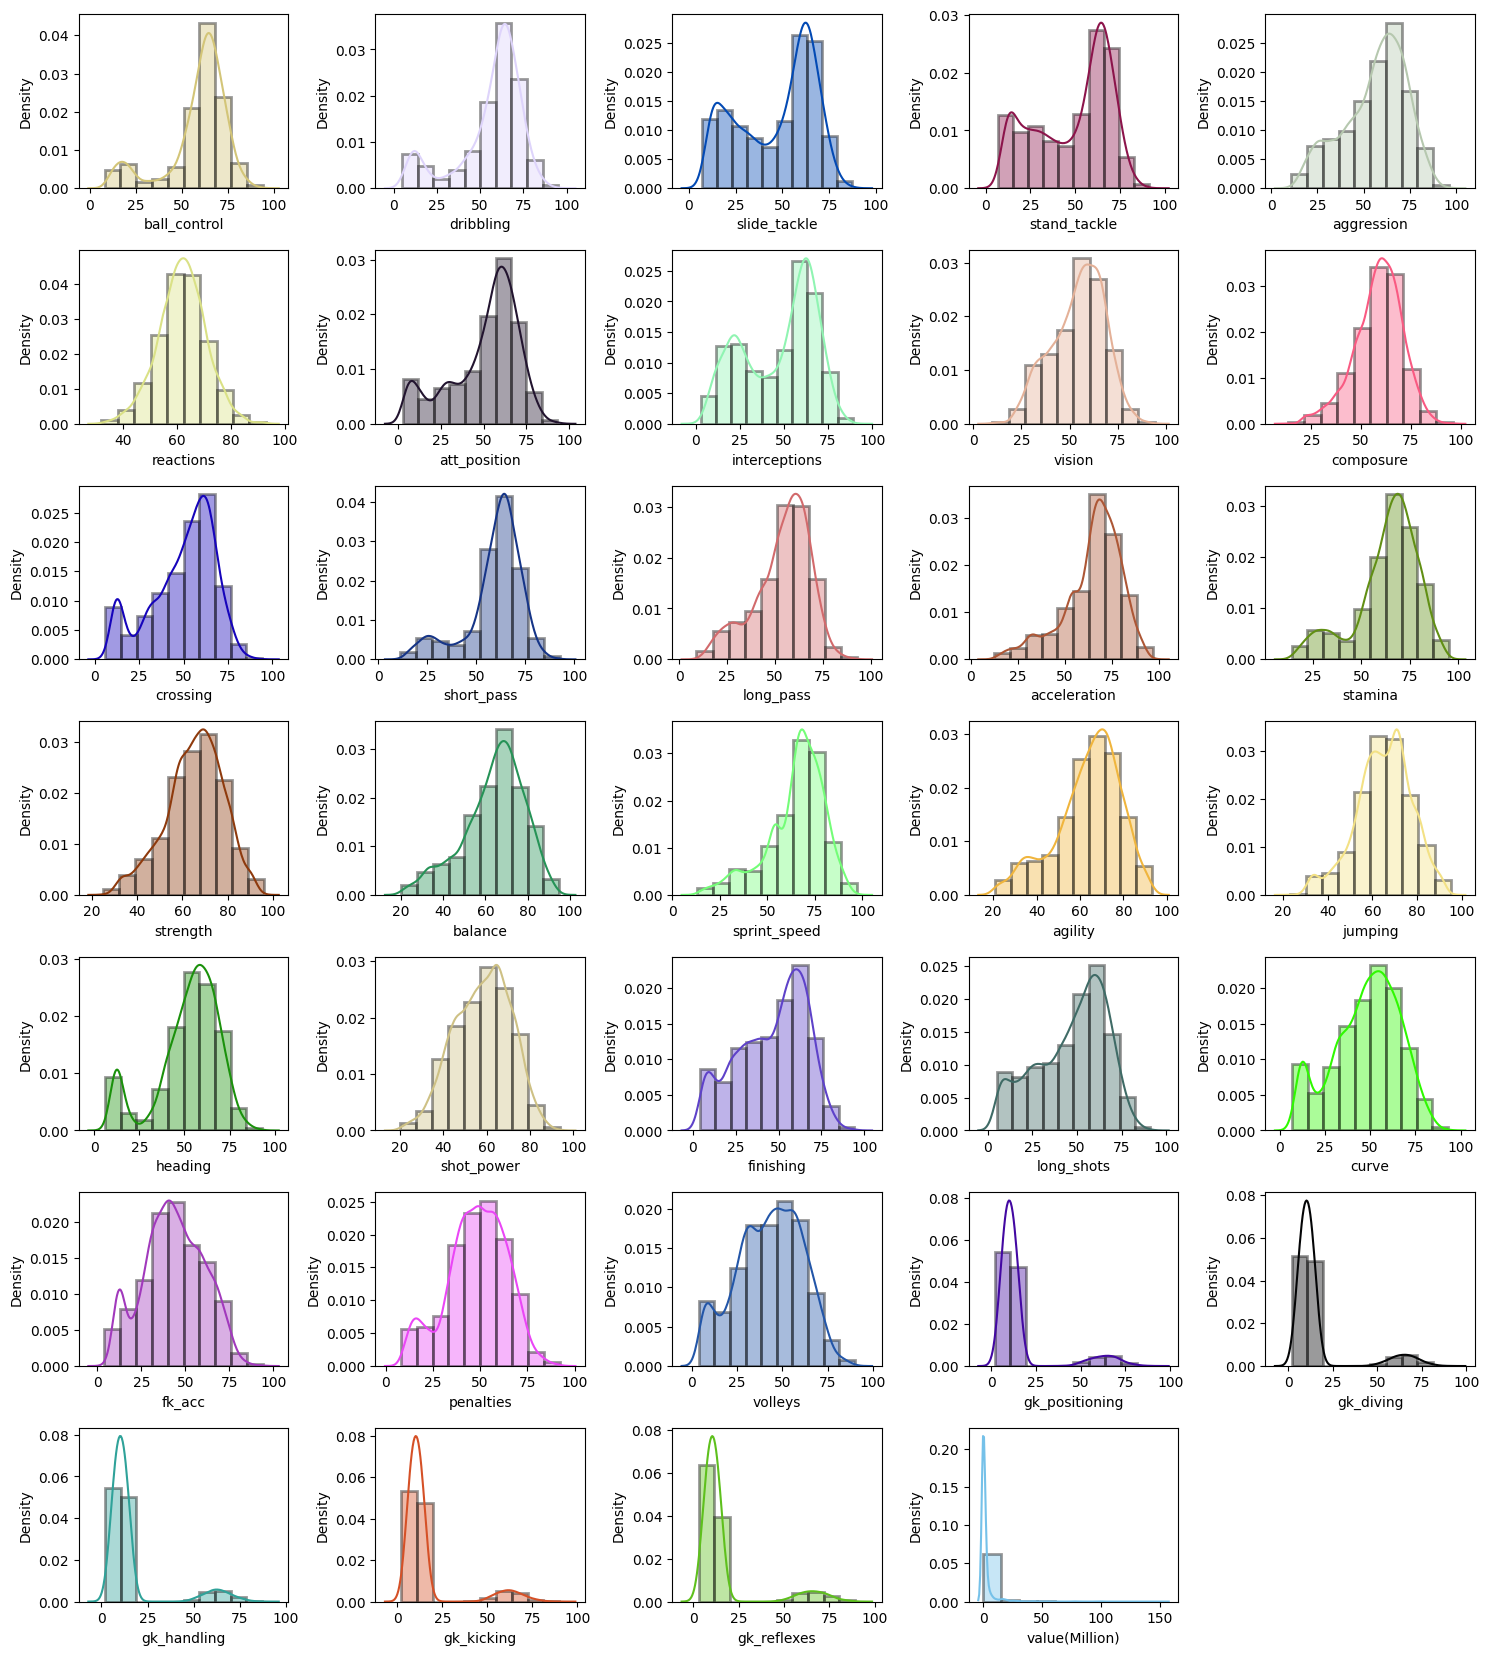

In [ ]:
print('[Numeric Features Distribution'.center(100))

n = 5
cols = num_df.columns.tolist()[3:]
n_col = len(cols)
plt.figure(
    figsize=[15,4*math.ceil(n_col/n)])

for i in range(n_col):
    plt.subplot(math.ceil(n_col/3),n,i+1)
    sns.distplot(num_df[cols[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='value(Million)'>

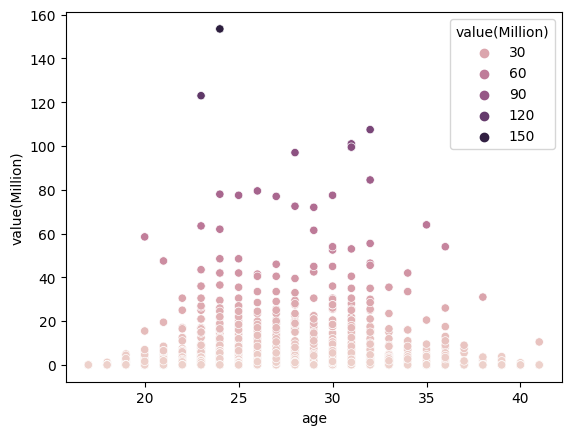

In [ ]:
#visualizing the distribution of player age and value
sns.scatterplot(x='age', y='value(Million)', data=data, hue=data['value(Million)'])

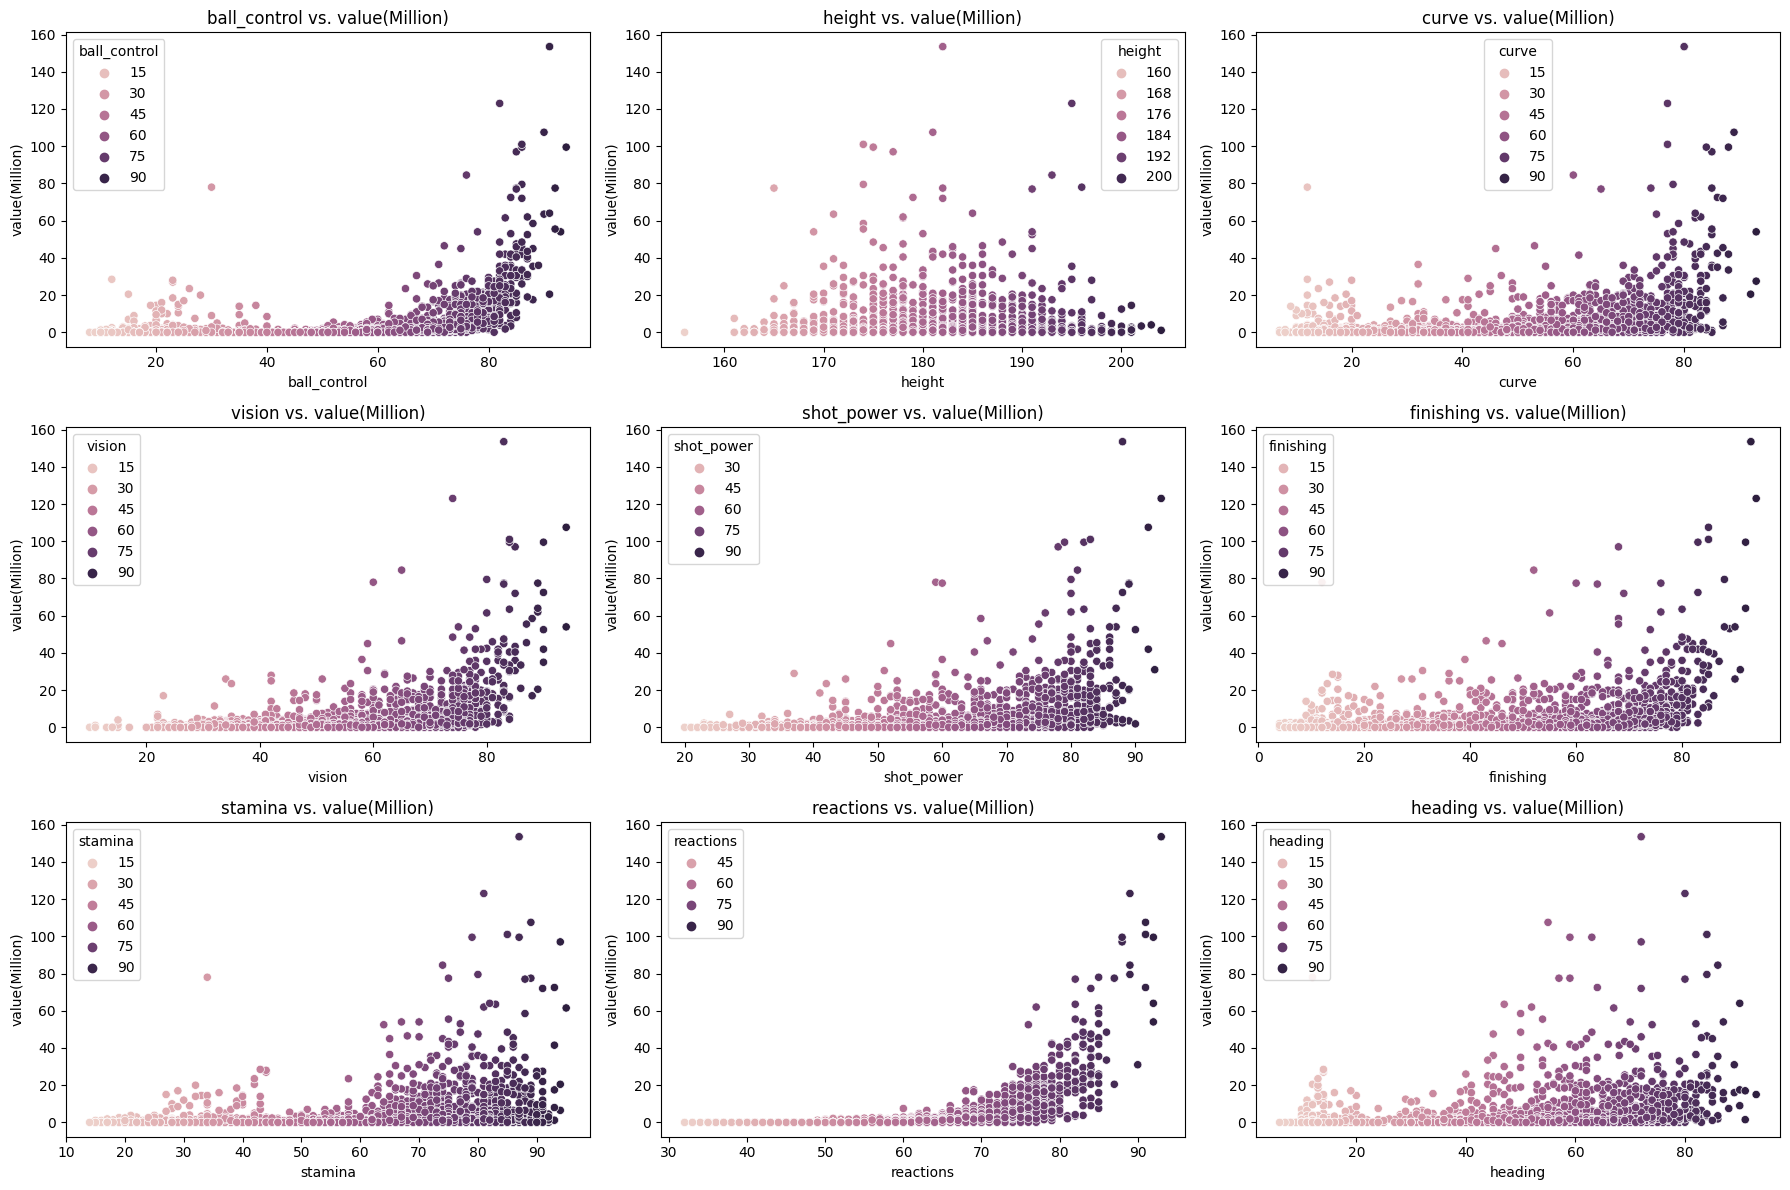

In [ ]:
# some important Features against 'value(Million)'
selected_features = ['ball_control', 'height', 'curve', 'vision', 'shot_power','finishing','stamina','reactions', 'heading']

# Scatterplots
plt.figure(figsize=(18, 12))  # Increase the figure size for more subplots

for index, feature in enumerate(selected_features, start=1):
    plt.subplot(3, 3, index)  # Adjust the subplot index and layout
    sns.scatterplot(x=data[feature], y=data['value(Million)'],hue=data[feature])
    plt.title(f'{feature} vs. value(Million)')
    plt.xlabel(feature)
    plt.ylabel('value(Million)')

plt.tight_layout()
plt.show()

<Axes: xlabel='heading', ylabel='height'>

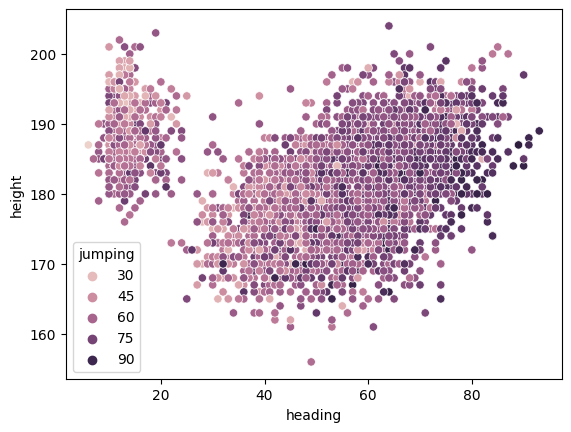

In [ ]:
# jumping vs heading
sns.scatterplot(x='heading', y='height', data=data, hue='jumping')

<Axes: xlabel='composure', ylabel='penalties'>

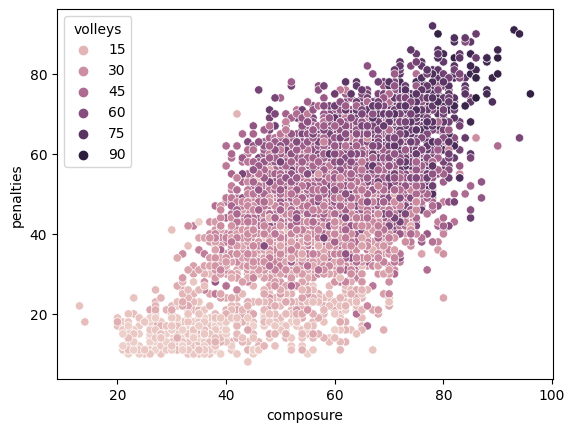

In [ ]:
sns.scatterplot(x='composure', y='penalties', data=data, hue='volleys')

<Axes: xlabel='ball_control', ylabel='finishing'>

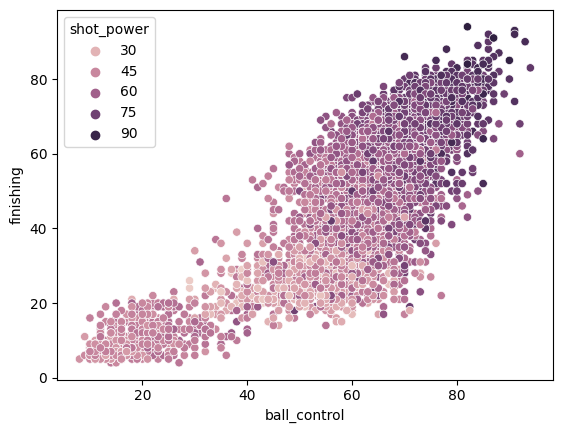

In [ ]:
sns.scatterplot(x='ball_control', y='finishing', data=data, hue='shot_power')

In [ ]:
#checking the z-scores of each column and removing outliers
def remove_outliers(df, threshold=4):
    z_scores = np.abs(stats.zscore(df))
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]
    return df_no_outliers

df1 = remove_outliers(num_df)

In [ ]:
#checking the correlation between the features
corr = df1.corr()
corr

,height,weight,age,ball_control,dribbling,slide_tackle,stand_tackle,aggression,reactions,att_position,interceptions,vision,composure,crossing,short_pass,long_pass,acceleration,stamina,strength,balance,sprint_speed,agility,jumping,heading,shot_power,finishing,long_shots,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes,value(Million)
height,1.000000,0.757623,0.079800,-0.413875,-0.492670,-0.127248,-0.124510,-0.091696,-0.004174,-0.446935,-0.110777,-0.370021,-0.191742,-0.520021,-0.351482,-0.322966,-0.554849,-0.307067,0.528904,-0.769817,-0.458435,-0.648274,0.036093,0.001643,-0.173986,-0.384167,-0.394885,-0.472881,-0.427731,-0.328342,-0.357731,0.361701,0.368961,0.367824,0.364232,0.370804,-0.014501
weight,0.757623,1.000000,0.216282,-0.337099,-0.408525,-0.107617,-0.102873,-0.016465,0.085509,-0.355817,-0.080291,-0.286229,-0.093117,-0.416128,-0.276505,-0.250997,-0.477296,-0.233844,0.592035,-0.635914,-0.394557,-0.545773,0.103899,0.029672,-0.077937,-0.305401,-0.297396,-0.377597,-0.329011,-0.241516,-0.267326,0.330899,0.334975,0.333197,0.332084,0.336364,0.017716
age,0.079800,0.216282,1.000000,0.089908,0.034002,0.091044,0.103901,0.242083,0.412765,0.105480,0.172079,0.197761,0.358459,0.129574,0.139459,0.182505,-0.137400,0.127822,0.350278,-0.048314,-0.126361,-0.020543,0.239954,0.159959,0.273306,0.092964,0.165624,0.145225,0.182816,0.157872,0.154232,0.099691,0.086274,0.093464,0.091959,0.092302,0.107281
ball_control,-0.413875,-0.337099,0.089908,1.000000,0.945477,0.451529,0.484307,0.612173,0.464135,0.872225,0.474656,0.702898,0.756102,0.838425,0.924182,0.806135,0.697914,0.749170,0.127840,0.638623,0.682515,0.713672,0.223218,0.707836,0.601966,0.805482,0.834269,0.834802,0.767496,0.778204,0.795458,-0.806294,-0.813322,-0.811866,-0.805890,-0.812283,0.314812
dribbling,-0.492670,-0.408525,0.034002,0.945477,1.000000,0.355003,0.384347,0.517949,0.392021,0.911971,0.371917,0.725140,0.694154,0.867581,0.856272,0.739753,0.757763,0.713164,0.012977,0.693115,0.731055,0.776340,0.152671,0.607642,0.606786,0.842763,0.852406,0.859097,0.779156,0.782157,0.814746,-0.780312,-0.786179,-0.784593,-0.782031,-0.786227,0.279385
slide_tackle,-0.127248,-0.107617,0.091044,0.451529,0.355003,1.000000,0.978104,0.735910,0.253377,0.196868,0.947670,0.140979,0.368821,0.453370,0.565533,0.612200,0.237277,0.590577,0.277643,0.238525,0.250713,0.193860,0.309411,0.547456,-0.022225,0.012868,0.172529,0.296593,0.254798,0.106964,0.072282,-0.549897,-0.550496,-0.549108,-0.547874,-0.549029,0.129801
stand_tackle,-0.124510,-0.102873,0.103901,0.484307,0.384347,0.978104,1.000000,0.752677,0.280569,0.232524,0.955949,0.177094,0.405272,0.472753,0.598294,0.637153,0.247816,0.611341,0.297196,0.249852,0.262137,0.212249,0.310326,0.569567,0.014309,0.052487,0.211732,0.328475,0.286929,0.142941,0.112531,-0.571694,-0.570942,-0.569965,-0.568678,-0.570134,0.150137
aggression,-0.091696,-0.016465,0.242083,0.612173,0.517949,0.735910,0.752677,1.000000,0.424802,0.448950,0.755258,0.325194,0.574212,0.506177,0.669366,0.641237,0.312589,0.677376,0.471894,0.278473,0.342372,0.298118,0.437500,0.725924,0.296372,0.317179,0.427803,0.448320,0.411423,0.384147,0.366029,-0.615469,-0.617492,-0.616510,-0.614299,-0.614858,0.233949
reactions,-0.004174,0.085509,0.412765,0.464135,0.392021,0.253377,0.280569,0.424802,1.000000,0.394707,0.334771,0.516180,0.680913,0.373806,0.523339,0.499463,0.198046,0.405085,0.334318,0.174291,0.205584,0.263608,0.301495,0.378479,0.503898,0.353607,0.415908,0.407101,0.375580,0.364442,0.390121,-0.090421,-0.099251,-0.097386,-0.096299,-0.093509,0.577293
att_position,-0.446935,-0.355817,0.105480,0.872225,0.911971,0.196868,0.232524,0.448950,0.394707,1.000000,0.232087,0.747241,0.664656,0.807638,0.773073,0.641679,0.694398,0.665354,0.040426,0.635560,0.671131,0.724291,0.143845,0.571360,0.672522,0.909313,0.886369,0.837204,0.776902,0.821988,0.863322,-0.700313,-0.709475,-0.705454,-0.701533,-0.705773,0.266857


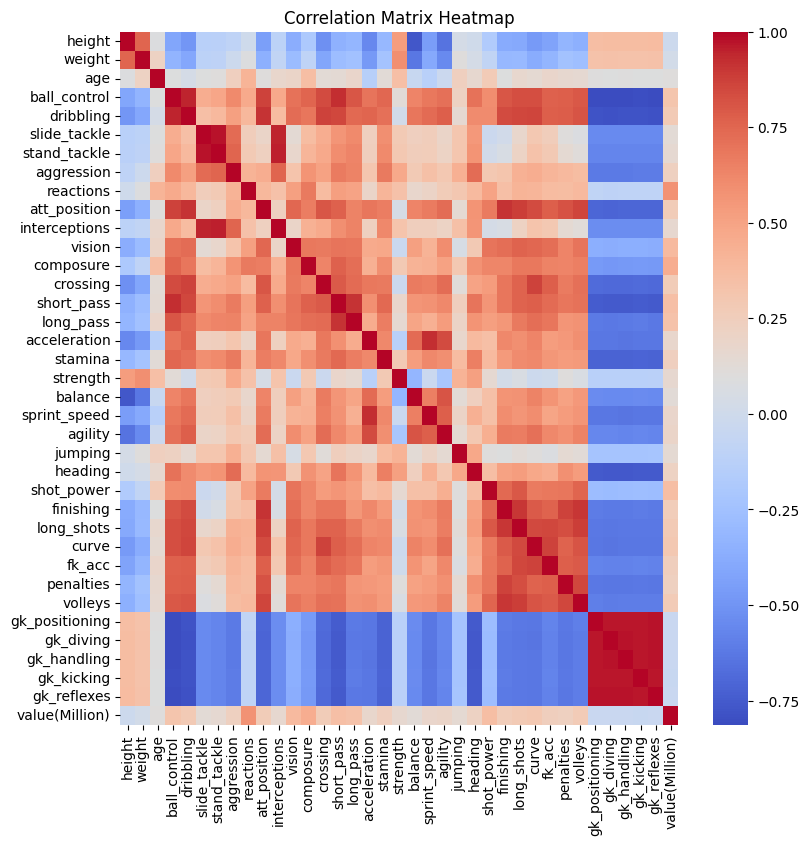

In [ ]:
# Create a correlation heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## Modelling

#### Linear Regression

In [ ]:
x = df1.drop(["value(Million)"], axis=1)
y = df1["value(Million)"]

In [ ]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
print('coefficent', model.coef_)
y_predic = model.predict(X_test)

coefficent [-0.00727529 -0.00928096 -0.15751558  0.01619889 -0.00417776 -0.0221649
  0.04463797  0.00671385  0.18867297 -0.00874274 -0.02213278  0.01143373
  0.04157265  0.02288023  0.02574913 -0.00644989  0.01010097 -0.00165274
 -0.00147339 -0.01856662  0.01860726 -0.01331291  0.00467647  0.02501076
  0.01304601  0.02260983 -0.01372643  0.01013206 -0.00576691 -0.02762697
  0.01534511  0.01488576  0.02776853  0.01999293  0.00691474  0.01799636]


In [ ]:
print("root mean squared error", np.sqrt(mean_squared_error(y_test,y_predic)))
print("r2_score", r2_score(y_test,y_predic))

root mean squared error 3.233079991126887
r2_score 0.3896136375378023


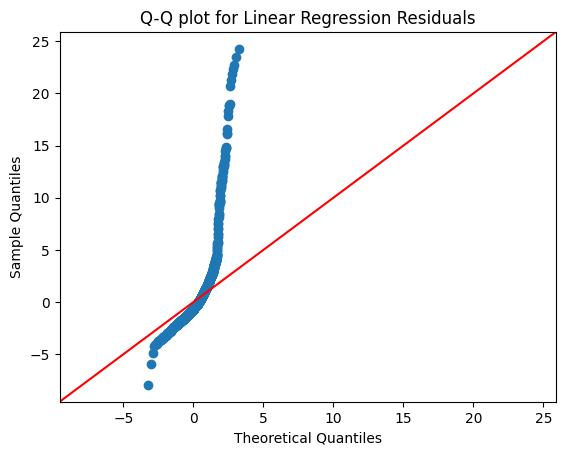

In [ ]:
# Residuals for Linear model with all the features
residuals = y_test - y_predic
# Q-Q plot for linear model
sm.qqplot(residuals, line ='45')
plt.title('Q-Q plot for Linear Regression Residuals')
plt.show()

#### OLS:

In [ ]:
ols = sm.OLS(y, x).fit()
res = ols.resid
print_ols_summary = ols.summary()
print(print_ols_summary)

                                 OLS Regression Results                                
Dep. Variable:         value(Million)   R-squared (uncentered):                   0.489
Model:                            OLS   Adj. R-squared (uncentered):              0.485
Method:                 Least Squares   F-statistic:                              148.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:23:16   Log-Likelihood:                         -14212.
No. Observations:                5618   AIC:                                  2.850e+04
Df Residuals:                    5582   BIC:                                  2.873e+04
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [ ]:
print("root mean squared error", np.sqrt(mean_squared_error(y_test,ols.predict(X_test))))

root mean squared error 3.2228573462432357


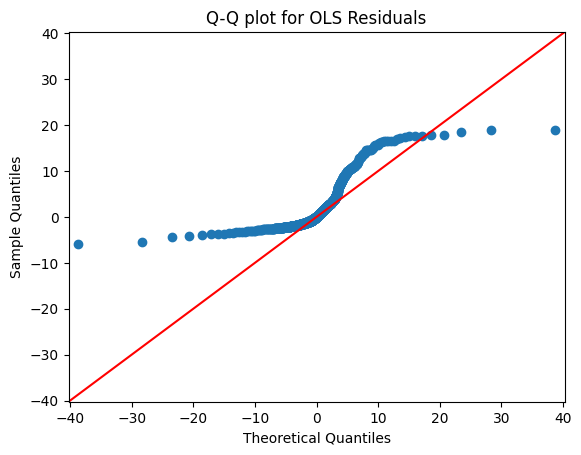

In [ ]:
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.title('Q-Q plot for OLS Residuals')
plt.show()

#### OLS with Logarithmic Transformation

In [ ]:
#applying logarithmic transformation
log_model = sm.OLS(np.log(y), x).fit()
log_res = log_model.resid
print_model = log_model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:         value(Million)   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                              731.1
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:23:17   Log-Likelihood:                         -8830.2
No. Observations:                5618   AIC:                                  1.773e+04
Df Residuals:                    5582   BIC:                                  1.797e+04
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [ ]:
print("root mean squared error", np.sqrt(mean_squared_error(y_test,log_model.predict(X_test))))

root mean squared error 4.723467923706871


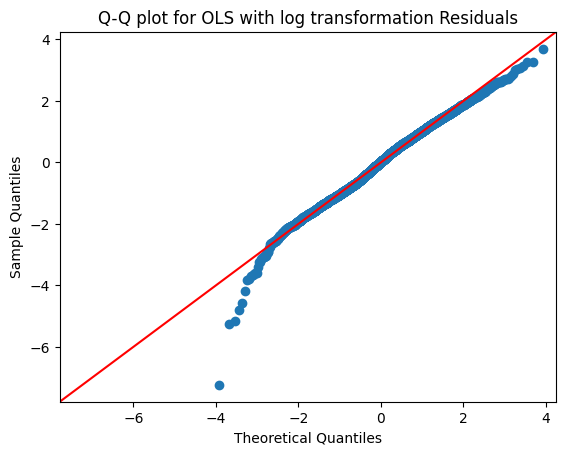

In [ ]:
fig = sm.qqplot(log_res, stats.t, fit=True, line="45")
plt.title('Q-Q plot for OLS with log transformation Residuals')
plt.show()

#### OLS with Box-Cox Transformation

In [ ]:
# Applying box-cox transformation
yt, _ = stats.boxcox(y.values)
box_cox_model = sm.OLS(yt, x).fit()
bc_res = box_cox_model.resid
print_model = box_cox_model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.839
Model:                            OLS   Adj. R-squared (uncentered):              0.838
Method:                 Least Squares   F-statistic:                              808.9
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:23:18   Log-Likelihood:                         -9646.1
No. Observations:                5618   AIC:                                  1.936e+04
Df Residuals:                    5582   BIC:                                  1.960e+04
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [ ]:
print("root mean squared error", np.sqrt(mean_squared_error(y_test,box_cox_model.predict(X_test))))

root mean squared error 5.044379120417317


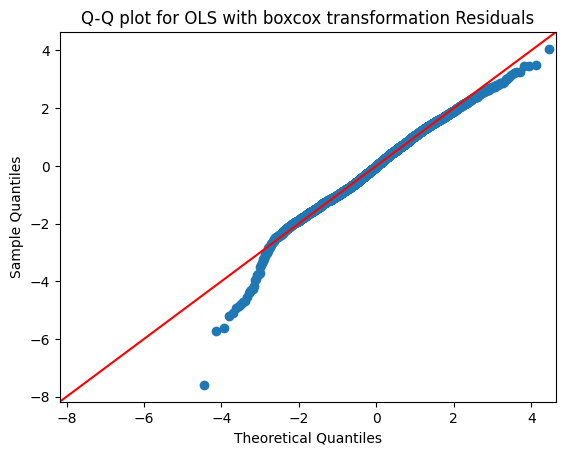

In [ ]:
fig = sm.qqplot(bc_res, stats.t, fit=True, line="45")
plt.title('Q-Q plot for OLS with boxcox transformation Residuals')
plt.show()

#### Ridge Regression

In [ ]:
ridge = Ridge(alpha=1.0)
ridge.fit(x, y)

Ridge()

In [ ]:
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))
print("Ridge RMSE:", ridge_rmse)
print("r2_score", r2_score(y_test,ridge.predict(X_test)))

Ridge RMSE: 3.2049928647223513
r2_score 0.4001729372757731


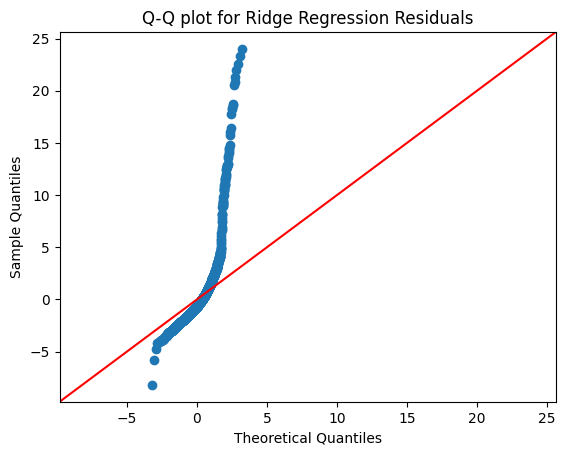

In [ ]:
# Residuals for Ridge model
ridge_residuals = y_test - ridge.predict(X_test)
# Q-Q plot for Ridge model
sm.qqplot(ridge_residuals, line ='45')
plt.title('Q-Q plot for Ridge Regression Residuals')
plt.show()

#### Lasso Regression

In [ ]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

Lasso()

In [ ]:
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
print("Lasso RMSE:", lasso_rmse)
print("r2_score", r2_score(y_test,lasso.predict(X_test)))

Lasso RMSE: 3.2830299287585074
r2_score 0.37060743844397737


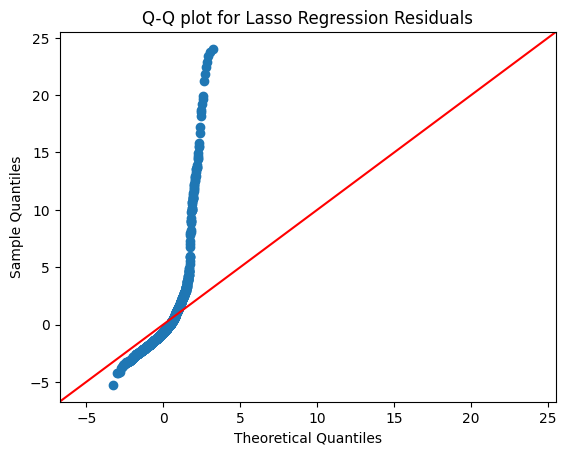

In [ ]:
# Residuals for Lasso model
lasso_residuals = y_test - lasso.predict(X_test)
# Q-Q plot for Lasso model
sm.qqplot(lasso_residuals, line ='45')
plt.title('Q-Q plot for Lasso Regression Residuals')
plt.show()

## Model Improvements

### Using Regression models paired with ensembling techniques:

#### Random Forest Regressor

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators= 100, random_state=0,n_jobs=-1)
rf_regressor.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [ ]:
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_regressor.predict(X_test)))
print("randomforest regressor rmse:",rf_rmse)
print("r2_score", r2_score(y_test,rf_regressor.predict(X_test)))

randomforest regressor rmse: 1.5152210320565866
r2_score 0.865932379285945


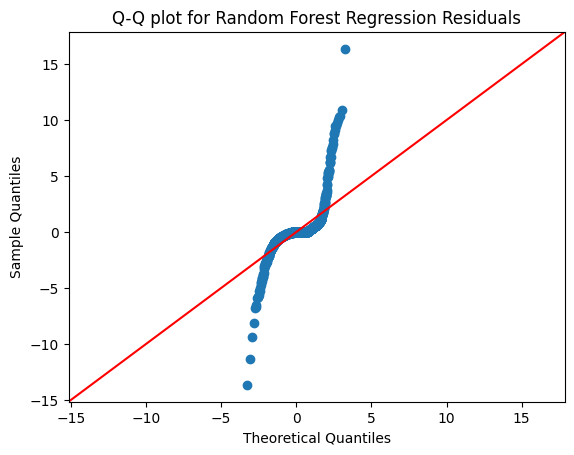

In [ ]:
# Residuals for Randomforestregressor model
rf_residuals = y_test - rf_regressor.predict(X_test)
# Q-Q plot for Randomforestregressor model
sm.qqplot(rf_residuals, line ='45')
plt.title('Q-Q plot for Random Forest Regression Residuals')
plt.show()

#### XGBoost Regressor

In [ ]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))
print("xgbregressor rmse:",xgb_rmse)
print("r2_score", r2_score(y_test,xgb_model.predict(X_test)))

xgbregressor rmse: 1.5255279598790699
r2_score 0.8641022501782685


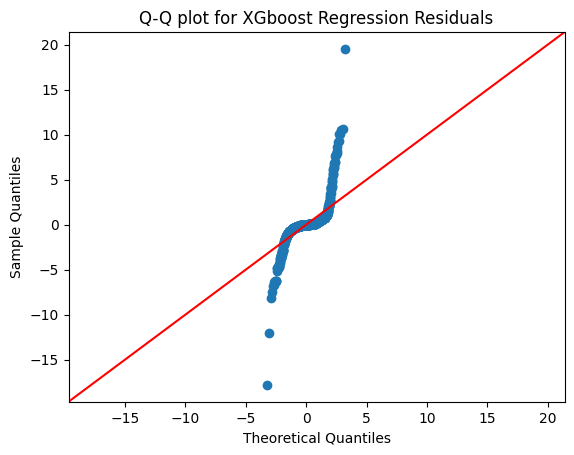

In [ ]:
# Residuals for xgb regressor model
xgb_residuals = y_test - xgb_model.predict(X_test)
# Q-Q plot for xgbregressor model
sm.qqplot(xgb_residuals, line ='45')
plt.title('Q-Q plot for XGboost Regression Residuals')
plt.show()

### Dealing with collinearity to improve the model:

#### Feature Selection with regularisation

In [ ]:
from sklearn.feature_selection import SelectFromModel
# normalizing the features
x_norm = StandardScaler().fit_transform(x)

sel = SelectFromModel(Ridge(alpha=1.0, random_state=42))
sel.fit(x_norm,y)

SelectFromModel(estimator=Ridge(random_state=42))

In [ ]:
#isolating the features using SelectFromModel
sel.get_support()
select_feat = x.columns[(sel.get_support())]

In [ ]:
# best features for modelling after feature selection
select_feat

Index(['age', 'stand_tackle', 'reactions', 'interceptions', 'composure',
       'crossing', 'short_pass', 'heading', 'finishing', 'long_shots', 'curve',
       'gk_positioning', 'gk_diving', 'gk_handling'],
      dtype='object')

In [ ]:
#creating a new dataframe for modelling by using the selected features
x_mod = x[select_feat]
x_mod.shape

(5618, 14)

In [ ]:
#train-test split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(x_mod, y, test_size=0.3, random_state=42)

In [ ]:
def plot_prediction_analysis(y, y_predic, figsize=(9,5), title=''):
  fig, axs = plt.subplots(1, 2, figsize=figsize)
  axs[0].scatter(y, y_predic)
  mn = min(np.min(y), np.min(y_predic))
  mx = max(np.max(y), np.max(y_predic))
  axs[0].plot([mn, mx], [mn, mx], c='red')
  axs[0].set_xlabel('$y$')
  axs[0].set_ylabel('$\hat{y}$')
  rmse = np.sqrt(mean_squared_error(y, y_predic))
  evs = explained_variance_score(y, y_predic)
  r2 = r2_score(y, y_predic)
  axs[0].set_title('rmse = {:.2f}, evs = {:.2f}, r2 = {:,.2f}'.format(rmse, evs, r2))

  if title!='':
    fig.suptitle(title)

  axs[1].hist(y - y_predic, bins=20, edgecolor='black')
  axs[1].set_xlabel('$y - \hat{y}$')
  axs[1].set_title('Residuals Histogram')


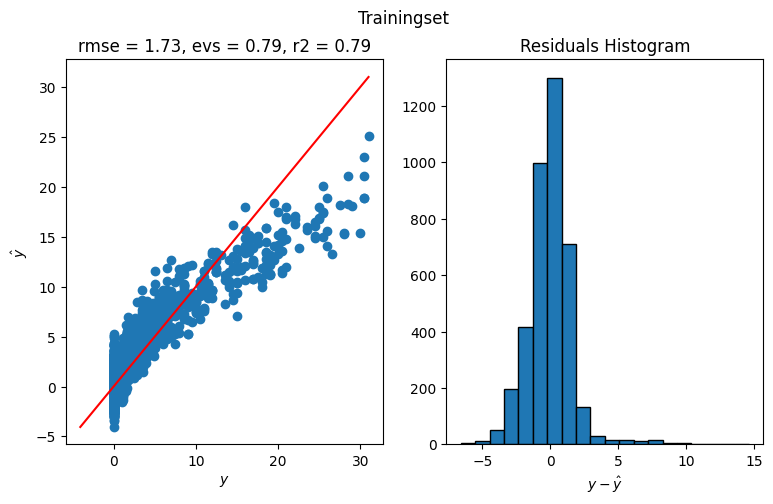

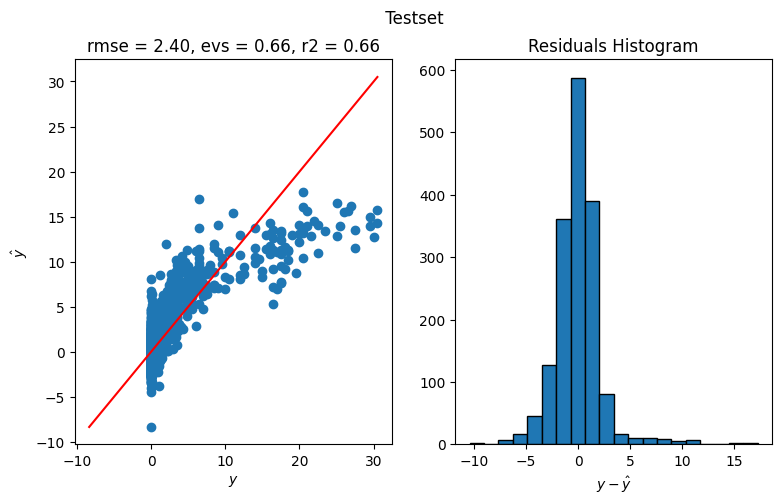

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


model = Pipeline((("standard_scalar", StandardScaler()),("poly",PolynomialFeatures(degree=2)),("lin_reg", Ridge(alpha=1.0))))
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Trainingset')
y_test_pred = model.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title=' Testset')

In [ ]:
xgb_sel = XGBRegressor()
xgb_sel.fit(Xs_train, ys_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgbs_rmse = np.sqrt(mean_squared_error(ys_test, xgb_sel.predict(Xs_test)))
print("xgbregressor rmse:",xgbs_rmse)
print("r2_score", r2_score(ys_test,xgb_sel.predict(Xs_test)))

xgbregressor rmse: 1.671625262274219
r2_score 0.8368264456548775


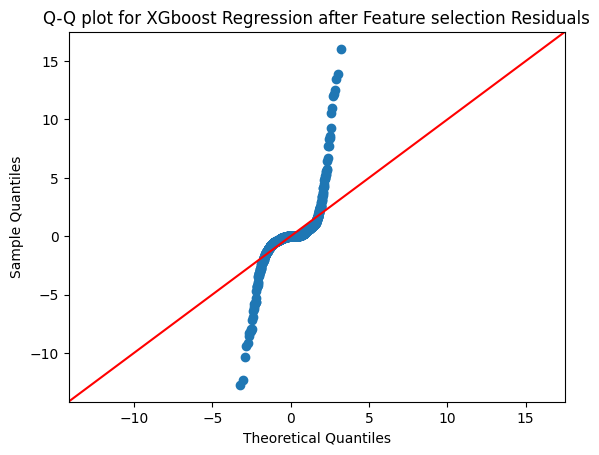

In [ ]:
# Residuals for xgb regressor model
xgbs_residuals = ys_test - xgb_sel.predict(Xs_test)
# Q-Q plot for xgbregressor model
sm.qqplot(xgbs_residuals, line ='45')
plt.title('Q-Q plot for XGboost Regression after Feature selection Residuals')
plt.show()

#### Feature reduction with Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

In [ ]:
pca_x = pca.fit_transform(x)
pca_df = pd.DataFrame(pca_x, columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])
pca_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,23.217662,66.272203,4.466042,32.645218,21.441835,12.543969,3.500600,0.237863,14.282826,3.020604
1,-45.258266,6.120627,25.553941,2.900264,4.844420,15.529464,17.251148,-14.714937,-17.909587,-9.667687
2,175.409340,-26.471139,35.838177,-12.040700,-20.453046,7.468002,6.546820,-2.139612,3.431169,-3.978138
3,22.584712,74.356469,-5.955996,20.742467,-13.462084,1.060642,-13.102025,-5.417785,-17.087084,9.179019
4,202.952479,-13.212449,11.381017,-4.152716,14.158240,22.829108,7.916872,-11.447617,5.914509,5.987600


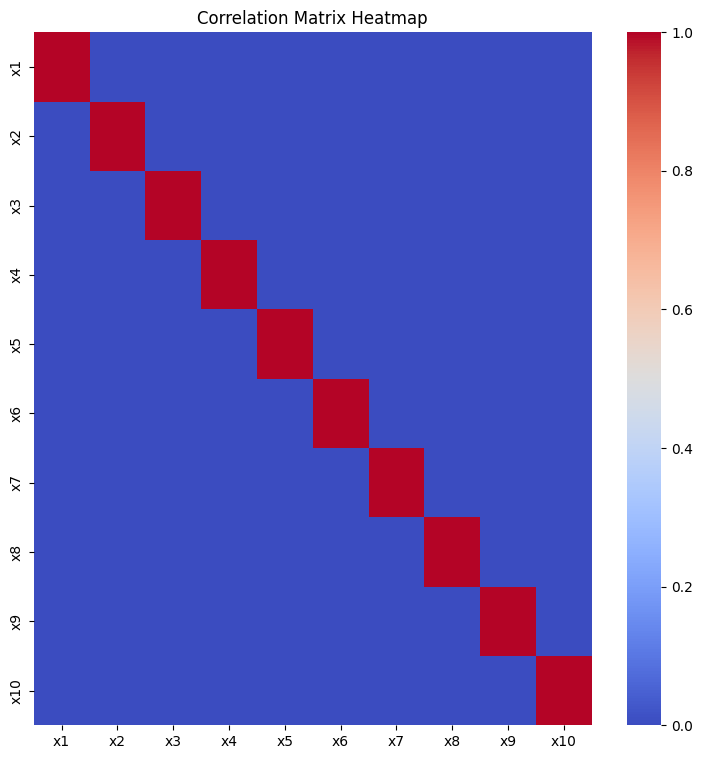

In [ ]:
#checking correlation after pca
corr1 = pca_df.corr()
# Create a correlation heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(corr1, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

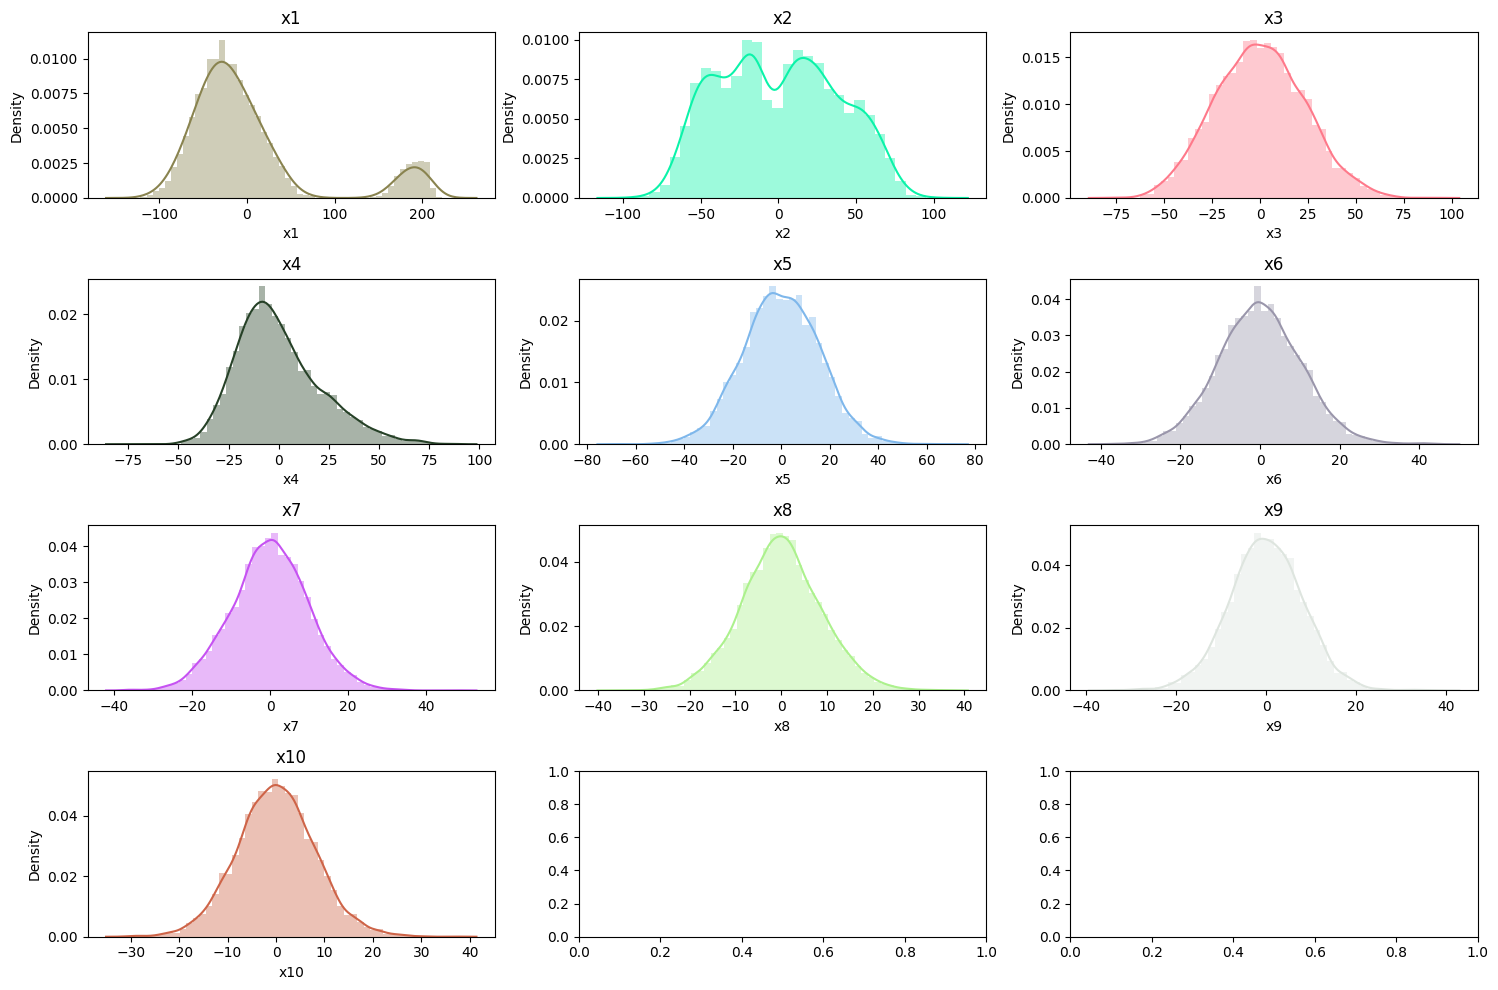

In [ ]:
cols = pca_df.columns.to_list()
num_cols = len(cols)
num_rows = (num_cols + 2) //3
# Set up the subplot grid
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 10))
axes = axes.flatten()
for i, c in enumerate(cols):
    sns.distplot(pca_df[c], color=list(np.random.randint([255, 255, 255]) / 255), ax=axes[i])
    axes[i].set_title(c)

plt.tight_layout()
plt.show()

In [ ]:
#split the data into training and testing sets
Xp_train, Xp_test, yp_train, yp_test = train_test_split(pca_df, y, test_size=0.3, random_state=42)

In [ ]:
xgb_pca = XGBRegressor()
xgb_pca.fit(Xp_train, yp_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_pca_rmse = np.sqrt(mean_squared_error(yp_test, xgb_pca.predict(Xp_test)))
print("xgbregressor rmse:",xgb_pca_rmse)
print("r2_score", r2_score(yp_test,xgb_pca.predict(Xp_test)))

xgbregressor rmse: 1.8652648606041067
r2_score 0.7968331067374939


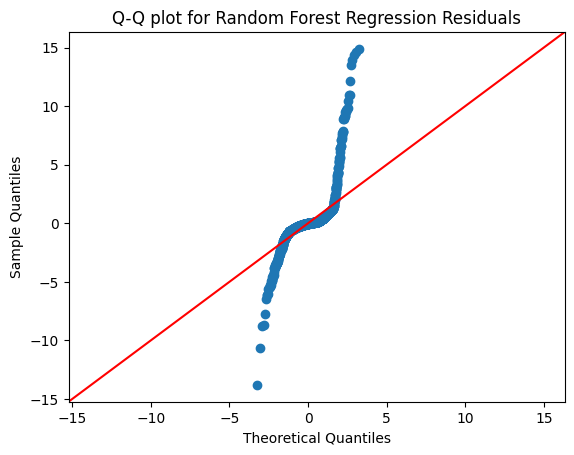

In [ ]:
# Residuals for xgbregressor model after pca
xgb_pca_residuals = yp_test - xgb_pca.predict(Xp_test)
# Q-Q plot for xgbregressor model after
sm.qqplot(xgb_pca_residuals, line ='45')
plt.title('Q-Q plot for XGBoost Regression with PCA Residuals')
plt.show()

#### Feature selection based on significance from Hypothesis Testing

In [ ]:
Hyp_df = df1[['vision', 'ball_control', 'crossing', 'curve','dribbling','height','weight','age','slide_tackle', 'stand_tackle','interceptions','short_pass','long_pass','stamina','strength','balance','agility','reactions','long_shots','shot_power','finishing']]

In [ ]:
#split the data into training and testing sets
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Hyp_df, y, test_size=0.3, random_state=42)

In [ ]:
xgb_hyp = XGBRegressor()
xgb_hyp.fit(Xh_train, yh_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_hyp_rmse = np.sqrt(mean_squared_error(yh_test, xgb_hyp.predict(Xh_test)))
print("xgbregressor rmse:",xgb_hyp_rmse)
print("r2_score", r2_score(yh_test,xgb_hyp.predict(Xh_test)))

xgbregressor rmse: 1.634440755713893
r2_score 0.8440051400707622


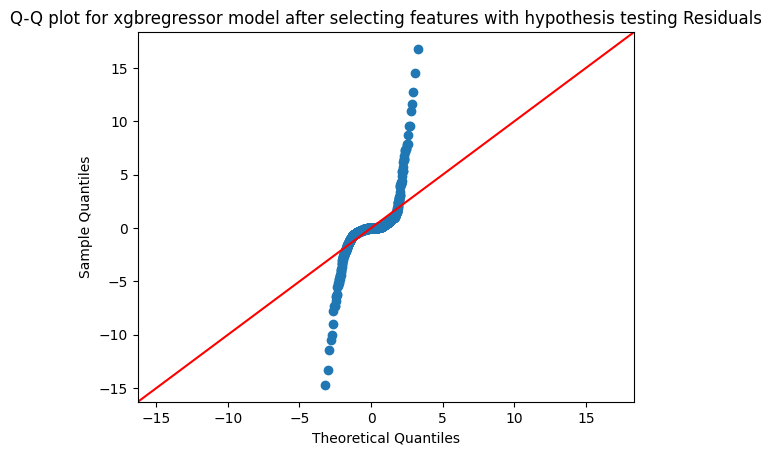

In [ ]:
# Residuals for xgbregressor model after selecting features with hypothesis testing
xgb_midfl_residuals = yh_test - xgb_hyp.predict(Xh_test)
# Q-Q plot for xgbregressor model after selecting features with hypothesis testing
sm.qqplot(xgb_midfl_residuals, line ='45')
plt.title('Q-Q plot for xgbregressor model after selecting features with hypothesis testing Residuals')
plt.show()

## Conclusion

Our project explored various regression models to predict football player values. Traditional linear regression methods, including Ordinary Least Squares (OLS) and transformations, offered limited performance. Regularized techniques like Ridge and Lasso showed marginal improvements. The Random Forest Regressor excelled with an impressive RMSE of 1.52 and an R-squared value of 0.87. The XGBoost Regressor further enhanced performance with an RMSE of 1.53 and an R-squared value of 0.86.

Feature selection techniques, especially with XGBoost and hypothesis testing, proved effective in maintaining accuracy while improving interpretability. However, addressing multicollinearity with Principal Component Analysis (PCA) and XGBoost resulted in a trade-off, reducing features to 10 principal components but slightly lowering the R-squared value to 0.79.

In conclusion, Random Forest and XGBoost Regressors are robust choices that outperform traditional linear methods. Careful consideration of feature selection techniques is crucial, balancing simplicity and explanatory power.